<a href="https://colab.research.google.com/github/Sandi-DeLaVega/Tensorflow-Practice/blob/main/Emotion_AI_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*From Udemy Course: Modern Artificial Intelligence Masterclass: Build 6 Projects
# Understand the Problem Statement and Business Case
##Artificial Emotional Intelligence or Emotion AI is a branch that allows computers to understand human non-verbal cues such as body language and facial expressions.
Affectiva offers cutting edge emotion AI tech:
https://www.affectiva.com/



#Project Overview
The aim of this project is to classify people's emotions based on their face images.
Working as an AI/ML consultat, train and deploy a system that automatically monitors people emotions and expressions.
The team collected more than 20000 facial images, with their associated facial expression labels and around 2000 images with their facial  key-point annotations.

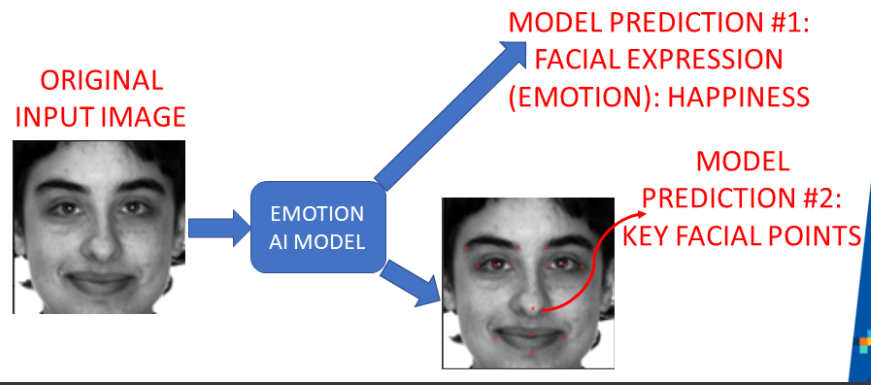

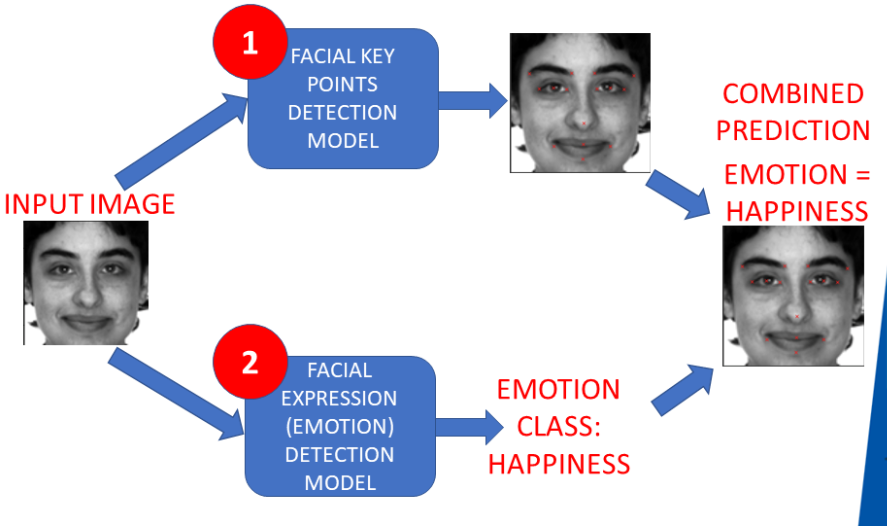

#Key Facial Points Detection
#####Creating a Deep Learning Model Based on Convolutional Neural Network and Residual Blocks to predict facial key-points
The dataset consists of x and y coordinates of 15 facial key points.
Input images are 96x96 pixels
Images consists of only one color channel (gray-scale images).

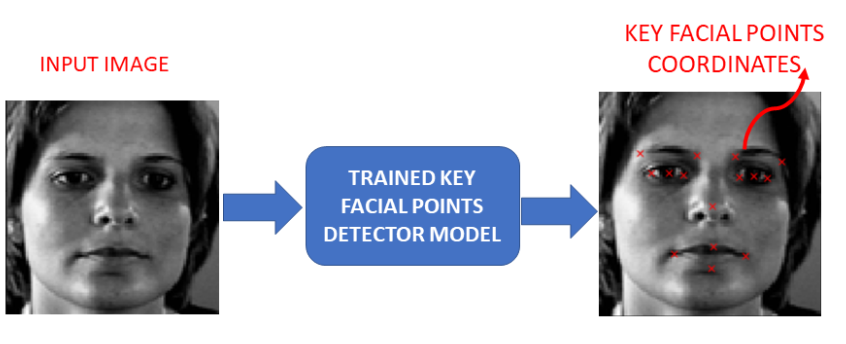

#Import Libraries and DataSets

In [1]:
#Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/EmotionAI_dataset/

/content/drive/My Drive/EmotionAI_dataset


In [4]:
#import the necessary packages
import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

In [5]:
#load facial key points data
keyfacial_df = pd.read_csv('/content/drive/My Drive/EmotionAI_dataset/data.csv')

In [6]:
keyfacial_df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [7]:
#Obtain relevant information about the dataframe
keyfacial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [8]:
keyfacial_df.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [9]:
keyfacial_df['Image'].shape

(2140,)

In [10]:
#Since Valeus for the Image column  are given as space separated string, separate the values using ' ' as separator.
#Then convert this into numpy array using np.fromstring and convert the obtained 1D array into 2D array of shape(96,96)
keyfacial_df['Image'] = keyfacial_df['Image'].apply(lambda x: np.fromstring(x, dtype = int, sep = ' ').reshape(96,96))

In [11]:
#Obtain the shape of the image
keyfacial_df['Image'][0].shape

(96, 96)

##Obtain the average, minimum and maximum values for right_eye_center_x

In [12]:
keyfacial_df.describe()['right_eye_center_x']

count    2140.000000
mean       29.640269
std         2.051575
min        18.922611
25%        28.472224
50%        29.655440
75%        30.858673
max        42.495172
Name: right_eye_center_x, dtype: float64

# Perform Image Visualization

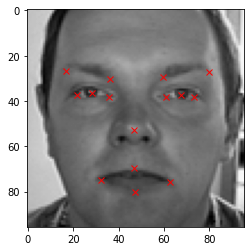

In [14]:
#Plot a random image from the dataset along with facial keypoints.
#Image data is obtained from df['Image] and plotted using plt.imshow
#15 x and y coordinates for the corresponding image
#since x-coordinates are in even columns like 0,2,4... and y - coordinates are in odd columns like 1,3,5,...
#we acces their value using .loc command, which get the values for coordinates of the image based on the column it is referring to.

#random picture
i = np.random.randint(1, len(keyfacial_df))
plt.imshow(keyfacial_df['Image'][i], cmap = 'gray')

#from the random picture, place x marks on the critical points
for j in range(1,31,2):
  plt.plot(keyfacial_df.loc[i][j - 1], keyfacial_df.loc[i][j], 'rx')

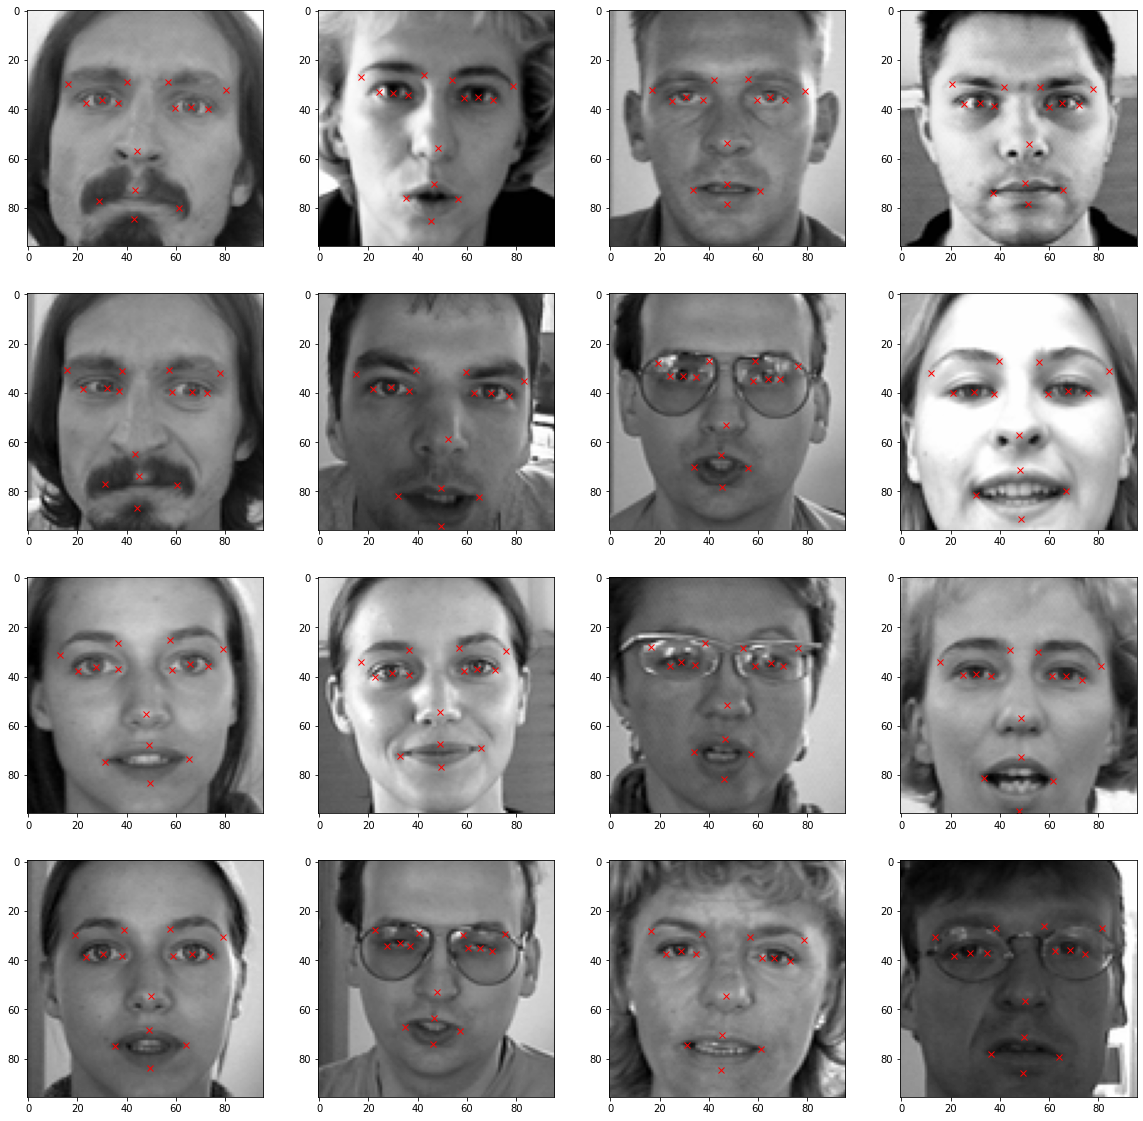

In [15]:
#View more images in a grid format
fig = plt.figure(figsize = (20,20))

for i in range(16):
  ax  = fig.add_subplot(4,4, i + 1)
  image = plt.imshow(keyfacial_df['Image'][i],cmap = 'gray')
  
  for j in range(1,31,2):
    plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j],'rx')

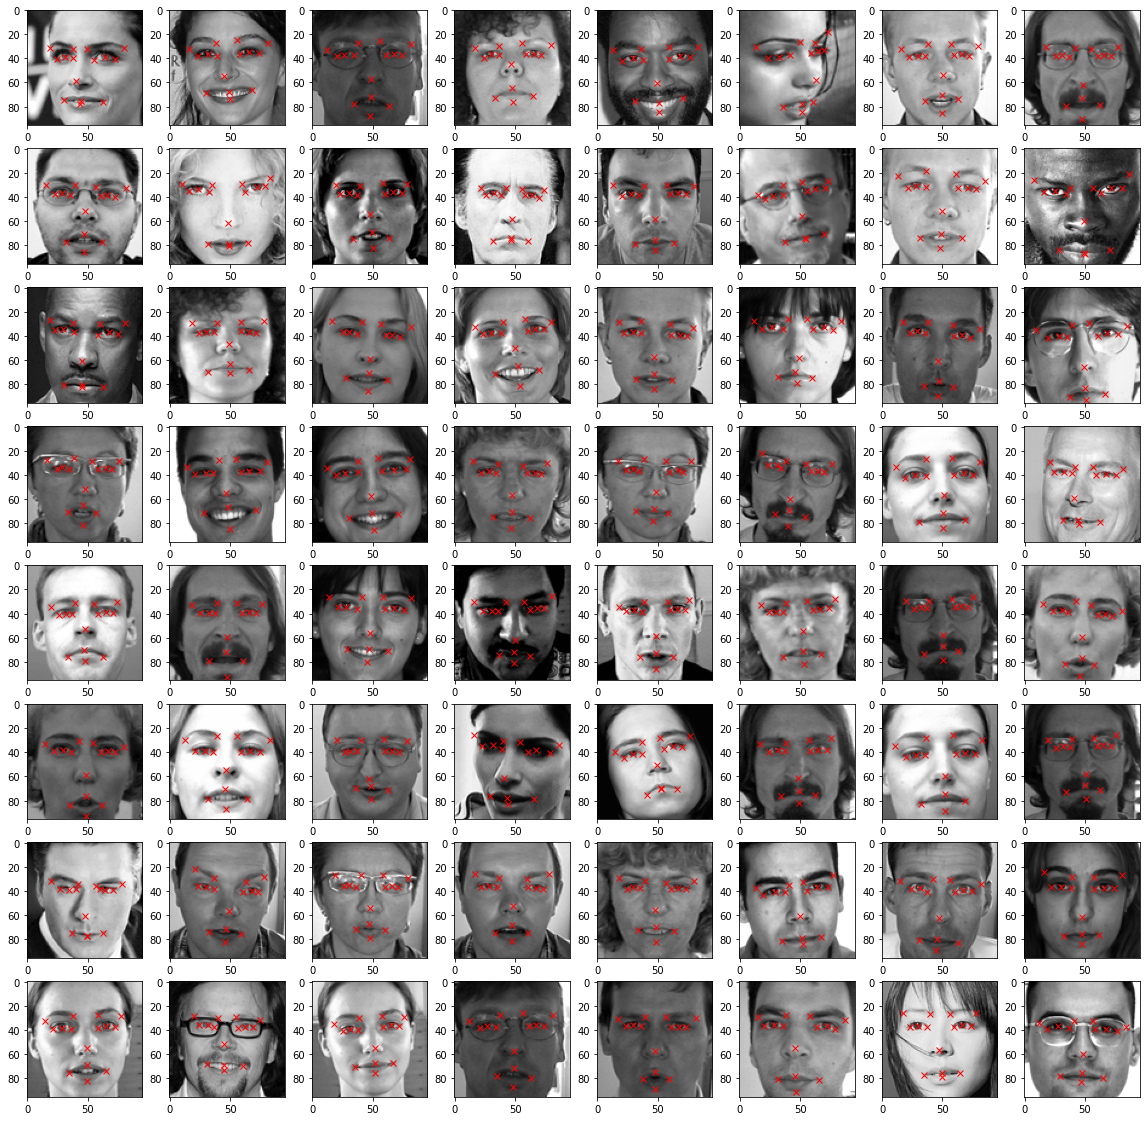

In [16]:
#Performing Sanity Check on the Data by Randomly Visualizing 64 new images along with their corresponding key points
import random
#view more images in grid format
fig = plt.figure(figsize = (20,20))

for i in range(64):
  k = random.randint(1, len(keyfacial_df))
  ax = fig.add_subplot(8,8, i + 1)
  image = plt.imshow(keyfacial_df['Image'][k], cmap = 'gray')

  for j in range(1,31,2):
    plt.plot(keyfacial_df.loc[k][j-1], keyfacial_df.loc[k][j],'rx')